## 1. 데이터 준비

In [1]:
%matplotlib inline
# Standard library imports
import datetime
import os
from copy import deepcopy
import pickle

# Third-party libraries imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import seaborn as sns
import random
from itertools import combinations

# from IPython.display import clear_output
from scipy.spatial import distance
from sklearn.decomposition import PCA

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchvision import datasets, transforms

# Local application/library specific imports
from data_utils import (generate_server_idcs, CustomSubset, split_3class_unbalanced, split_contain_multiclass,
                        split_7plus3class_unbalanced, CombinedCustomSubset)
from fl_devices import Server, Client
from helper import ExperimentLogger, display_train_stats
from models import ConvNet, Representation, Two_class_classifier, Ten_class_classifier, Four_class_classifier


torch.manual_seed(42)
np.random.seed(42)

In [2]:
LOCAL_EPOCHS = 25
N_CLIENTS = 6
NUMBER_OF_CLUSTER = 3
ALPHA = 0.1
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# data = datasets.CIFAR10(root="CIFAR10/", download=False)
data = datasets.MNIST(root="MNIST/", download=False)
idcs = np.random.permutation(len(data))

def cluster(server, clients, number_of_cluster):
    label_predicted = pd.DataFrame()
    # label_acc = pd.DataFrame()
    for i, client in enumerate(clients):
        pred = server.check_cluster(client.model)
        # print(f'pred: {pred}')
        label_predicted = pd.concat([label_predicted, pd.DataFrame(pred, index=[i])])
        # label_acc = pd.concat([label_acc, pd.DataFrame(acc, index=[i])])
    label_predicted.reset_index(drop=True, inplace=True)
    label_predicted.fillna(0, inplace=True)
    
    print(f'predicted label')
    print(label_predicted)

    cluster_idcs, number_of_cluster= server.cluster_clients(label_predicted)
    return label_predicted, cluster_idcs, number_of_cluster



def get_cluster_averages(df, cluster_idcs):
    cluster_averages = {}

    for i, cluster in enumerate(cluster_idcs):
        cluster_data = df.loc[cluster, :]
        cluster_average = cluster_data.mean()
        cluster_averages[i] = cluster_average

    cluster_averages_df = pd.DataFrame(cluster_averages).T

    # calculate percentage for each value in a row
    cluster_percentages_df = cluster_averages_df.div(cluster_averages_df.sum(axis=1), axis=0).multiply(100)

    # apply threshold and rounding
    cluster_percentages_df = cluster_percentages_df.where(cluster_percentages_df >= 5, 0).round()

    return cluster_percentages_df / 10


def get_cluster_weights(cluster_logits, cluster_weight_per_class):
    # Step 1: Find the class with the maximum value in each logit in cluster_logits
    # Assuming the dimension for classes is the second one
    max_classes = [torch.argmax(logit, dim=1) for logit in cluster_logits]
    
    print(max_classes)
    cluster_weights = []
    #c luster별로 
    for i, iogits in enumerate(cluster_logits):
        weights = []
        for j, logit in enumerate(logits):
            
            # print(f'max_classes: {max_classes[i][j]}')
            # print("Shape of cluster_weight_per_class[{}]: ".format(i), cluster_weight_per_class[i].shape)
            weights.append(max_classes[i][j])
        print(weights)
        cluster_weights.append(weights)

def visualize_clusters(label_predicted, real_cluster_distribution):
    # Reduce the dimension of the data
    pca = PCA(n_components=2)
    label_predicted_pca = pca.fit_transform(label_predicted)
    
    # Define colors for the clusters
    colors = ['blue', 'red', 'green', 'purple', 'orange', 'yellow', 'black']

    # Calculate the number of samples in each real cluster
    n_samples = len(label_predicted)
    real_cluster_sizes = [int(n_samples * dist) for dist in real_cluster_distribution]

    # Plot the clusters
    plt.figure(figsize=(8, 5))

    start_idx = 0  # To keep track of the start index of each real cluster
    for i, size in enumerate(real_cluster_sizes):
        end_idx = start_idx + size  # Calculate the end index for this real cluster
        color = colors[i % len(colors)]  # Determine the color for this real cluster

        # Scatter plot for points belonging to this real cluster
        for j in range(start_idx, end_idx):
            plt.scatter(label_predicted_pca[j, 0], label_predicted_pca[j, 1], c=color, s=50, label=f'Real Cluster {i+1}' if j == start_idx else "")

        start_idx = end_idx  # Update the start index for the next real cluster
    
    # Remove duplicate labels in legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), fontsize='large')

    # Remove x and y ticks
    plt.xticks([])
    plt.yticks([])

    plt.show()

#     # Print the real cluster distribution
#     print("Real cluster distribution:", real_cluster_distribution)

#     # Calculate and print each client's cluster identity based on the real_cluster_distribution
#     n_clients = len(label_predicted)
#     cumulative_distribution = [0] + [sum(real_cluster_distribution[:i+1]) for i in range(len(real_cluster_distribution))]
#     client_cluster_id_real = [next((i for i, val in enumerate(cumulative_distribution) if val > client_idx / n_clients), -1) - 1 for client_idx in range(n_clients)]

#     print("Real cluster identity for each client:", client_cluster_id_real)

#     # Print each client's cluster identity based on the clusters argument
#     client_cluster_id_predicted = [next((i for i, cluster in enumerate(clusters) if client_idx in cluster), -1) for client_idx in range(n_clients)]
#     print("Predicted cluster identity for each client:", client_cluster_id_predicted)




def test_acc(server, clients, cluster_distribution):
    
    # Get individual client accuracies
    acc_clients = [client.evaluate() for client in clients]

    # Compute the average accuracy for each client
    client_acc = round(sum(acc_clients) / len(acc_clients), 3) if len(acc_clients) > 0 else 0

    # Compute cluster accuracies for this iteration
    cluster_accs_iteration = []
    start_idx = 0
    for distribution in cluster_distribution:
        end_idx = start_idx + int(distribution * len(clients))
        cluster_acc = round(sum(acc_clients[start_idx:end_idx]) / (end_idx - start_idx) + 0.000001, 3)
        cluster_accs_iteration.append(cluster_acc)
        start_idx = end_idx

    # Compute global accuracy for this iteration
    accuracies = [server.evaluate_distil(client.classifier) for client in clients]
    global_acc = round(np.mean(accuracies), 3)
    
    return client_acc, cluster_accs_iteration, global_acc


def get_global_logits(client_logits):
    avg_logits = torch.mean(torch.stack(client_logits), dim=0)
    return avg_logits

# def get_cluster_logits(client_logits, cluster_idcs):
#     cluster_logits = []
#     for i, cluster in enumerate(cluster_idcs):
#         cluster_client_logits = [client_logits[i] for i in cluster]
#         avg_cluster_logits = torch.mean(torch.stack(cluster_client_logits), dim=0)
#         cluster_logits.append(avg_cluster_logits)
#     return cluster_logits


def get_cluster_averages(df, cluster_idcs):
    cluster_averages = {}

    for i, cluster in enumerate(cluster_idcs):
        cluster_data = df.loc[cluster, :]
        cluster_average = cluster_data.mean()
        cluster_averages[i] = cluster_average

    cluster_averages_df = pd.DataFrame(cluster_averages).T

    # calculate percentage for each value in a row
    cluster_percentages_df = cluster_averages_df.div(cluster_averages_df.sum(axis=1), axis=0).multiply(100)

    # apply threshold and rounding
    cluster_percentages_df = cluster_percentages_df.where(cluster_percentages_df >= 5, 0).round()

    return cluster_percentages_df / 10

def compute_accuracy(global_logits, data_targets, server_idcs):
    """
    Compute accuracy of predictions based on global logits.

    Args:
    - global_logits (list of Tensors): Each Tensor represents the logits for a data instance, 
                                       and its size is the number of classes.
    - data_targets (list of ints): List of true labels for all data.
    - server_idcs (list of ints): Indices of data instances we're interested in.

    Returns:
    - accuracy (float): Computed accuracy.
    """
    true_labels = [data_targets[i] for i in server_idcs]
    
    correct_predictions = 0
    total_predictions = len(true_labels)

    for logits, label in zip(global_logits, true_labels):
        predicted_label = np.argmax(logits.cpu().numpy())  # Convert Tensor to numpy and get index of max value
        if predicted_label == label:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy


def save_tensor_to_csv(tensor, filename):
    # Convert tensor to numpy array
    array = tensor.cpu().detach().numpy()
    
    # Save numpy array to CSV file
    np.savetxt(filename, array, delimiter=",")

# def get_cluster_weights(cluster_logits, cluster_weight_per_class):
#     # Step 1: Find the class with the maximum value in each logit in cluster_logits
#     # Assuming the dimension for classes is the second one
#     max_classes = [torch.argmax(logit, dim=1) for logit in cluster_logits]
    
#     print(max_classes)
#     cluster_weights = []
#     #c luster별로 
#     for i, iogits in enumerate(cluster_logits):
#         weights = []
#         for j, logit in enumerate(logits):
            
#             # print(f'max_classes: {max_classes[i][j]}')
#             # print("Shape of cluster_weight_per_class[{}]: ".format(i), cluster_weight_per_class[i].shape)
#             weights.append(max_classes[i][j])
#         print(weights)
#         cluster_weights.append(weights)


In [4]:
def BC_experiments(total_client_data, distill_data, alpha, number_of_cluster, cluster_distribution):
    print(f'number_of_cluster: {number_of_cluster}')
    data_per_class=int(distill_data//10)
    train_idcs, test_idcs = idcs[:total_client_data], idcs[total_client_data:(total_client_data + int(distill_data * 2))]
    train_labels = data.targets
    test_labels = data.targets
    
    server_idcs = generate_server_idcs(test_idcs, test_labels, int(distill_data//10))

    # client_idcs = split_noniid(train_idcs, train_labels, alpha=alpha, n_clients=N_CLIENTS)
    client_idcs, major_class_per_client = split_7plus3class_unbalanced(train_idcs, train_labels, N_CLIENTS, cluster_distribution)
    
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))

    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(ConvNet, lambda x : torch.optim.Adam(x, weight_decay=0.1),test_data)

    clients = [Client(Representation, dat, major_class_per_client[i], i) 
           for i, dat in enumerate(client_data) if len(dat) > 20]
    
    print(f'client count: {len(clients)}')

    client_accs = []
    cluster_accs = []
    global_accs = []
    client_logits = []
    
    # For Fast experiment
    
    # 1. Classifier
    # for i, client in enumerate(clients):
    #     Total_data = CustomSubset(data, np.concatenate((server_idcs, client_idcs[i])), transforms.Compose([transforms.ToTensor()]))
    #     model = client.learn_representation(Total_data, client.model)


    print('train classifier')
    
    
    for i, client in enumerate(clients):
        client.classifier = Ten_class_classifier(client.model).to(device)
        client.train_binary_classifier(lr = 1e-3)
        client.train_classifier(lr = 1e-3)

    client_accs, cluster_accs, global_accs = test_acc(server, clients, cluster_distribution)
    print(f'client_acc: {client_accs[-1]}, cluster_acc: {cluster_distribution}: {cluster_accs[-1]},  global_acc: {global_accs[-1]}')
    
    print('get_global_logit')
    print("")
    
    # 2. get client loigt
    for i, client in enumerate(clients):
        client_logit = server.get_clients_logit_simclr(client.binary_classifier, client.classifier, client.major_class)
        client_logits.append(client_logit)
    

    # 3. make global logit
    global_logits = server.get_global_logits(client_logits)
    accuracy = compute_accuracy(global_logits, test_labels, server_idcs)
    
    print(f"Global Logit's Accuracy: {accuracy * 100:.2f}%")
    
    cluster_logits,  cluster_idcs = server.get_cluster_logits(client_logits, number_of_cluster)
    clustering_acc = server.evaluate_clustering(cluster_distribution, cluster_idcs)
    print(f'clustering_acc: {clustering_acc}')

    
    distill_loaders = []
    
    for cluster_logit in cluster_logits:
        distill_loader = server.create_distill_loader(data, server_idcs, cluster_logit)
        distill_loaders.append(distill_loader)
        
    # 4.Distillation
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        
        cluster_idx = next(j for j, cluster in enumerate(cluster_idcs) if i in cluster)
   
    
        client.distill((distill_loaders[cluster_idx]))
    
    client_accs, cluster_accs, global_accs = test_acc(server, clients, client_accs, cluster_accs, global_accs, cluster_distribution)
    
    print(f'total_client_data: {total_client_data}, cluster_distribution: {cluster_distribution}')
    print(f'acc before distill: {client_accs[-2]}, {cluster_accs[-2]}, {global_accs[-2]}')
    print(f'last acc: {client_accs[-1]}, {cluster_accs[-1]}, {global_accs[-1]}')
    return client_accs, cluster_accs, global_accs

In [5]:
# client_accs, cluster_accs, global_accs = SimCLR_distill_experiments(50000, 5000, 1, 3, [1/3, 1/3, 1/3])


In [6]:
def make_global_logit(n_clients, total_client_data, distill_data, number_of_cluster, cluster_distribution, instance_per_class, instances_per_class_per_client):
    data_per_class=int(distill_data//10)
    train_idcs, test_idcs = idcs[:total_client_data], idcs[total_client_data:(total_client_data + int(distill_data * 2))]
    train_labels = data.targets
    test_labels = data.targets
    
    server_idcs = generate_server_idcs(test_idcs, test_labels, int(distill_data//10))

    # client_idcs = split_noniid(train_idcs, train_labels, alpha=alpha, n_clients=N_CLIENTS)
    client_idcs = split_contain_multiclass(train_idcs, train_labels, n_clients, instance_per_class, instances_per_class_per_client)
    
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))

    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(ConvNet, lambda x : torch.optim.Adam(x),test_data)

    clients = [Client(Representation, dat, i) 
           for i, dat in enumerate(client_data) if len(dat) > 20]
    
    # print(f'client count: {len(clients)}')

    client_logits = []
    
        
    # 1. Train classifier
    for i, client in enumerate(clients):
        client.classifier = Ten_class_classifier(client.model).to(device)
        client.train_classifier(lr=1e-3)

    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    # 2. get client loigt
    for i, client in enumerate(clients):
        client_logits.append(server.get_clients_logit(client.classifier))

    # 3. make global logit
    global_logits = server.get_global_logits(client_logits)
    accuracy = compute_accuracy(global_logits, test_labels, server_idcs)
    
    print(f"Global Logit's Accuracy: {accuracy * 100:.2f}%")
    
    return server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution, client_acc, cluster_accs, global_acc

def distill_with_cluster_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution):
    cluster_logits,  cluster_idcs, label_predicted = server.get_cluster_logits(client_logits, number_of_cluster)
    visualize_clusters(label_predicted, cluster_distribution)
    silhouette, ari = server.evaluate_clustering(label_predicted, cluster_distribution, cluster_idcs)
    print(f'silhouette: {silhouette}, ari: {ari}')
    
    cluster_distill_loaders = []
    
    for cluster_logit in cluster_logits:
        distill_loader = server.create_distill_loader(data, server_idcs, cluster_logit)
        cluster_distill_loaders.append(distill_loader)
        
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        
        cluster_idx = next(j for j, cluster in enumerate(cluster_idcs) if i in cluster)
        
        client.distill((cluster_distill_loaders[cluster_idx]))
    
    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    return client_acc, cluster_accs, global_acc

def distill_with_global_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution):
    distill_loader = server.create_distill_loader(data, server_idcs, global_logits)
    
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        client.distill(distill_loader)
    
    client_acc, cluster_accs, global_acc = test_acc(server, clients, cluster_distribution)
    
    return client_acc, cluster_accs, global_acc

def copy_classifiers(clients):
    classifiers_state = []
    for client in clients:
        classifier_state = client.classifier.state_dict()
        classifiers_state.append(classifier_state)
    return classifiers_state


In [7]:
def cluster_train_result_exp(n_clients, total_client_data, distill_data, number_of_cluster, cluster_distribution, instance_per_class, instances_per_class_per_client):
   
    client_accs = []
    cluster_accs = []
    global_accs = []
    
    (
        server, clients, client_logits, global_logits,
        number_of_cluster, server_idcs, cluster_distribution,
        new_client_acc, new_cluster_accs, new_global_acc
    ) = make_global_logit(
        n_clients, total_client_data, distill_data,
        number_of_cluster, cluster_distribution,
        instance_per_class, instances_per_class_per_client
    )

    
    print(f'acc before distill: {new_client_acc}, {new_cluster_accs}, {new_global_acc}')
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)

    classifiers_state = copy_classifiers(clients)
    
    new_client_acc, new_cluster_accs, new_global_acc = distill_with_global_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution)
    
    
    for i, client in enumerate(clients):
        client.classifier.load_state_dict(classifiers_state[i])
    
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)
    
    new_client_acc, new_cluster_accs, new_global_acc = distill_with_cluster_logit(server, clients, client_logits, global_logits, number_of_cluster, server_idcs, cluster_distribution)
   
    
    client_accs.append(new_client_acc)
    cluster_accs.append(new_cluster_accs)
    global_accs.append(new_global_acc)
    
    print(f'acc after global distill: {client_accs[1]}, {cluster_accs[1]}, {global_accs[1]}')
    print(f'acc after cluster distill: {client_accs[-1]}, {cluster_accs[-1]}, {global_accs[-1]}')
    return client_accs, cluster_accs, global_accs

def get_combination(array_length, class_per_cluster):
    if class_per_cluster == 1:
        combinations = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
    elif class_per_cluster == 2:
        combinations = [[0,1], [2,3], [4,5], [6,7], [8,9], [0,5], [1,6], [2,7], [3,8], [4,9], [0,3], [1,4], [2,5], [6,8], [7,9], [0,4], [1,5], [2,9], [3,7], [8,6]]
    elif class_per_cluster == 3:
        combinations = [[0,1,2], [3,4,5], [6,7,8], [9,0,1], [2,3,4], [5,6,7], [8,9,0], [1,2,3], [4,5,6], [7,8,9]]
    elif class_per_cluster == 4:
        combinations = [[0,1,2,3],[4,5,6,7],[8,9,0,1],[2,3,4,5],[6,7,8,9],[2,4,6,8],[1,3,5,9],[0,3,6,9],[1,4,7,0],[2,5,8,1]]
    elif class_per_cluster == 5:
        combinations = [[0,1,2,3,4],[4,5,6,7,8],[8,9,0,1,2],[2,3,4,5,6],[6,7,8,9,0],[2,4,6,8,0],[1,3,5,7,9],[0,2,3,6,9],[1,4,6,7,0],[2,5,6,8,1]]
    else:
        return "Invalid class_per_cluster"
    
    return combinations[:array_length]


[[0], [1]]
Epoch 5 - Train Loss: 1.8367, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 10 - Train Loss: 0.7921, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 15 - Train Loss: 0.0332, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 20 - Train Loss: 0.0003, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 25 - Train Loss: 0.0000, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 30 - Train Loss: 0.0000, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Global Logit's Accuracy: 16.94%
acc before distill: 1.0, [1.0, 1.0], 0.434
client 0 distill
label_predicted:         0       1    2    3    4    5    6    7    8    9
0  5000.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  5000.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  5000.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  5000.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4  5000.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5     0.0  5000.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
6

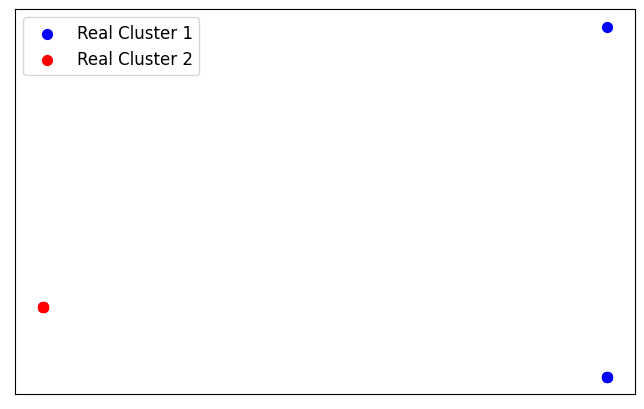

silhouette: 1.0, ari: 1.0
client 0 distill
acc after global distill: 0.453, [0.387, 0.52], 0.439
acc after cluster distill: 1.0, [1.0, 1.0], 0.434
[[0, 1], [2, 3]]
Epoch 5 - Train Loss: 1.9512, Train Accuracy: 50.00%, Eval Accuracy: 50.00%
Epoch 10 - Train Loss: 1.0180, Train Accuracy: 50.00%, Eval Accuracy: 50.00%
Epoch 15 - Train Loss: 0.6031, Train Accuracy: 92.86%, Eval Accuracy: 60.00%
Epoch 20 - Train Loss: 0.5008, Train Accuracy: 90.00%, Eval Accuracy: 93.33%
Epoch 25 - Train Loss: 0.3603, Train Accuracy: 92.86%, Eval Accuracy: 93.33%
Epoch 30 - Train Loss: 0.2277, Train Accuracy: 94.29%, Eval Accuracy: 93.33%
Global Logit's Accuracy: 28.92%
acc before distill: 0.91, [0.993, 0.827], 0.491
client 0 distill
label_predicted:         0       1       2       3    4    5    6    7    8    9
0  3340.0  1660.0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  3203.0  1797.0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  2627.0  2373.0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  24

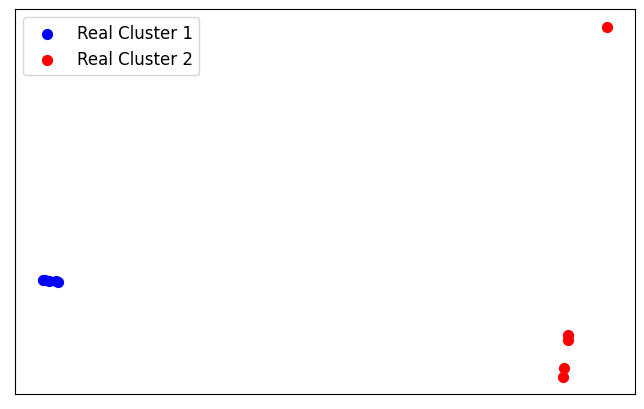

silhouette: 0.7799987196922302, ari: 1.0
client 0 distill
acc after global distill: 0.713, [0.987, 0.44], 0.925
acc after cluster distill: 0.953, [0.987, 0.92], 0.494
[[0, 1, 2], [3, 4, 5]]
Epoch 5 - Train Loss: 2.1074, Train Accuracy: 63.81%, Eval Accuracy: 55.56%
Epoch 10 - Train Loss: 1.5173, Train Accuracy: 58.10%, Eval Accuracy: 55.56%
Epoch 15 - Train Loss: 1.0367, Train Accuracy: 65.71%, Eval Accuracy: 77.78%
Epoch 20 - Train Loss: 0.9020, Train Accuracy: 85.71%, Eval Accuracy: 82.22%
Epoch 25 - Train Loss: 0.7462, Train Accuracy: 81.90%, Eval Accuracy: 77.78%
Epoch 30 - Train Loss: 0.5526, Train Accuracy: 85.71%, Eval Accuracy: 77.78%
Global Logit's Accuracy: 44.64%
acc before distill: 0.88, [0.933, 0.827], 0.476
client 0 distill
label_predicted:         0       1       2       3       4       5    6    7    8    9
0  1125.0   885.0  2990.0     0.0     0.0     0.0  0.0  0.0  0.0  0.0
1   828.0  1260.0  2912.0     0.0     0.0     0.0  0.0  0.0  0.0  0.0
2  1286.0  1734.0  1980.0

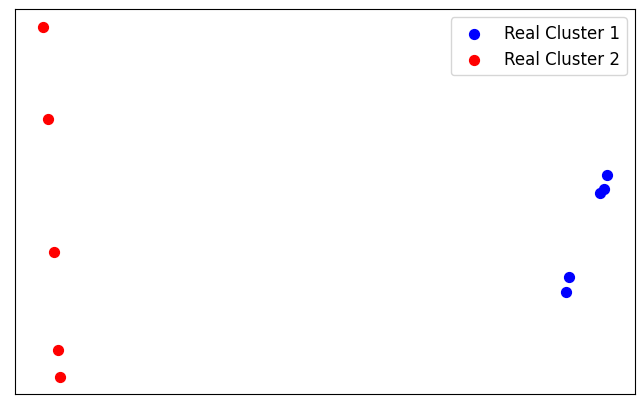

silhouette: 0.8046503067016602, ari: 1.0
client 0 distill
acc after global distill: 0.709, [0.911, 0.507], 0.942
acc after cluster distill: 0.907, [0.956, 0.858], 0.479
[[0, 1, 2, 3], [4, 5, 6, 7]]
Epoch 5 - Train Loss: 1.7851, Train Accuracy: 25.00%, Eval Accuracy: 25.00%
Epoch 10 - Train Loss: 1.3622, Train Accuracy: 25.00%, Eval Accuracy: 31.67%
Global Logit's Accuracy: 61.02%
acc before distill: 0.883, [0.923, 0.843], 0.466
client 0 distill
label_predicted:         0       1       2       3       4       5       6       7    8    9
0  1318.0   630.0   945.0  2107.0     0.0     0.0     0.0     0.0  0.0  0.0
1  1584.0  1071.0   975.0  1370.0     0.0     0.0     0.0     0.0  0.0  0.0
2   748.0   653.0   913.0  2686.0     0.0     0.0     0.0     0.0  0.0  0.0
3  1363.0   720.0  1041.0  1876.0     0.0     0.0     0.0     0.0  0.0  0.0
4   689.0   601.0  1167.0  2543.0     0.0     0.0     0.0     0.0  0.0  0.0
5     0.0     0.0     0.0     0.0   378.0  4437.0     0.0   185.0  0.0  0.0
6 

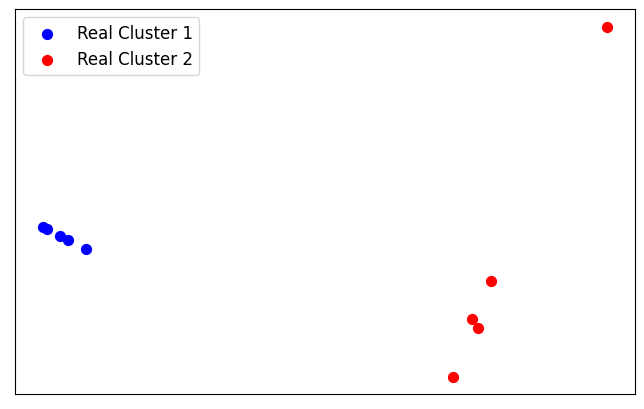

silhouette: 0.6763339042663574, ari: 1.0
client 0 distill
acc after global distill: 0.788, [0.913, 0.663], 0.919
acc after cluster distill: 0.955, [0.94, 0.97], 0.47
[[0, 1, 2, 3, 4], [4, 5, 6, 7, 8]]
Epoch 5 - Train Loss: 1.8320, Train Accuracy: 20.00%, Eval Accuracy: 20.00%
Epoch 10 - Train Loss: 1.5002, Train Accuracy: 57.14%, Eval Accuracy: 38.67%
Epoch 15 - Train Loss: 1.2281, Train Accuracy: 70.29%, Eval Accuracy: 72.00%
Epoch 20 - Train Loss: 0.7704, Train Accuracy: 81.71%, Eval Accuracy: 77.33%
Epoch 25 - Train Loss: 0.4499, Train Accuracy: 88.57%, Eval Accuracy: 82.67%
Epoch 30 - Train Loss: 0.2648, Train Accuracy: 92.57%, Eval Accuracy: 89.33%
Global Logit's Accuracy: 73.70%
acc before distill: 0.928, [0.939, 0.917], 0.473
client 0 distill
label_predicted:         0      1       2       3       4       5       6      7       8    9
0  1189.0  682.0   643.0  1142.0  1344.0     0.0     0.0    0.0     0.0  0.0
1   670.0  599.0  1341.0   918.0  1472.0     0.0     0.0    0.0     0

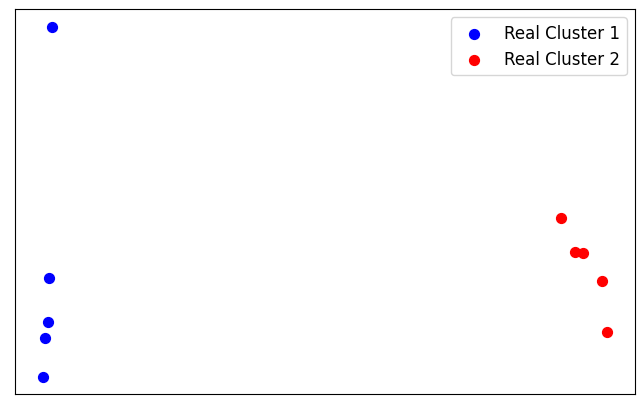

silhouette: 0.812724769115448, ari: 1.0
client 0 distill
acc after global distill: 0.777, [0.755, 0.8], 0.674
acc after cluster distill: 0.937, [0.944, 0.931], 0.48
[[0], [1], [2], [3]]
Epoch 5 - Train Loss: 1.9143, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 10 - Train Loss: 0.7018, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 15 - Train Loss: 0.0202, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 20 - Train Loss: 0.0002, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 25 - Train Loss: 0.0000, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 30 - Train Loss: 0.0000, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Global Logit's Accuracy: 16.64%
acc before distill: 1.0, [1.0, 1.0, 1.0, 1.0], 0.25
client 0 distill
client 10 distill
label_predicted:          0       1       2       3    4    5    6    7    8    9
0   5000.0     0.0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
1   5000.0     0.0     0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
2   5000.0

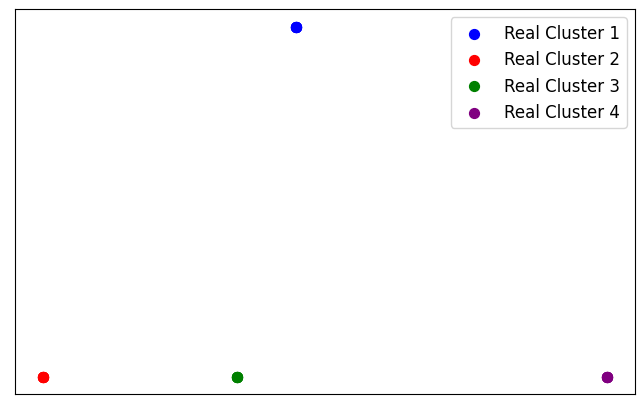

silhouette: 1.0, ari: 1.0
client 0 distill
client 10 distill
acc after global distill: 0.303, [0.227, 0.453, 0.267, 0.267], 0.269
acc after cluster distill: 1.0, [1.0, 1.0, 1.0, 1.0], 0.25
[[0, 1], [2, 3], [4, 5], [6, 7]]
Epoch 5 - Train Loss: 1.9443, Train Accuracy: 50.00%, Eval Accuracy: 50.00%
Epoch 10 - Train Loss: 0.9771, Train Accuracy: 50.00%, Eval Accuracy: 50.00%
Epoch 15 - Train Loss: 0.6150, Train Accuracy: 50.00%, Eval Accuracy: 60.00%
Epoch 20 - Train Loss: 0.5171, Train Accuracy: 88.57%, Eval Accuracy: 96.67%
Epoch 25 - Train Loss: 0.4226, Train Accuracy: 90.00%, Eval Accuracy: 96.67%
Epoch 30 - Train Loss: 0.3084, Train Accuracy: 91.43%, Eval Accuracy: 100.00%
Global Logit's Accuracy: 42.44%
acc before distill: 0.972, [0.973, 0.96, 0.953, 1.0], 0.246
client 0 distill
client 10 distill
label_predicted:          0       1       2       3       4       5       6       7    8    9
0   3288.0  1712.0     0.0     0.0     0.0     0.0     0.0     0.0  0.0  0.0
1   3244.0  1756.0

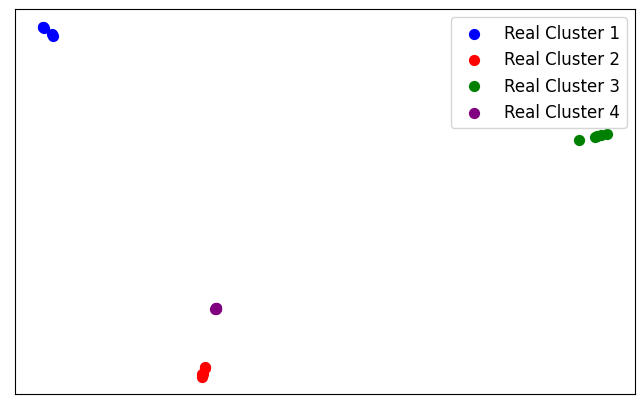

silhouette: 0.8826689720153809, ari: 1.0
client 0 distill
client 10 distill
acc after global distill: 0.548, [0.92, 0.147, 0.373, 0.753], 0.832
acc after cluster distill: 0.983, [0.987, 0.98, 0.973, 0.993], 0.246
[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1]]
Epoch 5 - Train Loss: 2.0430, Train Accuracy: 45.71%, Eval Accuracy: 37.78%
Epoch 10 - Train Loss: 1.3340, Train Accuracy: 46.67%, Eval Accuracy: 44.44%
Epoch 15 - Train Loss: 0.9734, Train Accuracy: 81.90%, Eval Accuracy: 75.56%
Epoch 20 - Train Loss: 0.8247, Train Accuracy: 84.76%, Eval Accuracy: 82.22%
Epoch 25 - Train Loss: 0.6298, Train Accuracy: 89.52%, Eval Accuracy: 88.89%
Epoch 30 - Train Loss: 0.4270, Train Accuracy: 92.38%, Eval Accuracy: 93.33%
Global Logit's Accuracy: 40.82%
acc before distill: 0.893, [0.956, 0.871, 0.791, 0.956], 0.445
client 0 distill
client 10 distill
label_predicted:          0       1       2       3       4       5       6       7       8  \
0    907.0  1345.0  2748.0     0.0     0.0     0.0     0

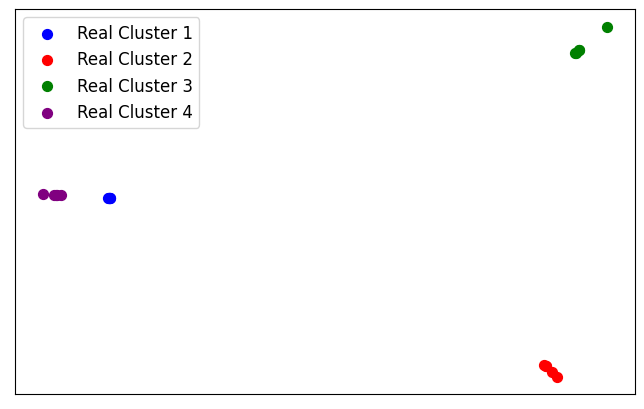

silhouette: 0.7656274437904358, ari: 1.0
client 0 distill
client 10 distill
acc after global distill: 0.494, [0.849, 0.107, 0.116, 0.907], 0.924
acc after cluster distill: 0.931, [0.964, 0.898, 0.907, 0.956], 0.451
[[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 0, 1], [2, 3, 4, 5]]
Epoch 5 - Train Loss: 1.5872, Train Accuracy: 25.00%, Eval Accuracy: 25.00%
Epoch 10 - Train Loss: 1.2180, Train Accuracy: 30.71%, Eval Accuracy: 25.00%
Epoch 15 - Train Loss: 1.0997, Train Accuracy: 48.57%, Eval Accuracy: 63.33%
Epoch 20 - Train Loss: 0.7486, Train Accuracy: 92.14%, Eval Accuracy: 81.67%
Epoch 25 - Train Loss: 0.4628, Train Accuracy: 95.00%, Eval Accuracy: 90.00%
Epoch 30 - Train Loss: 0.2059, Train Accuracy: 95.71%, Eval Accuracy: 91.67%
Global Logit's Accuracy: 57.22%
acc before distill: 0.909, [0.943, 0.903, 0.88, 0.91], 0.473
client 0 distill
client 10 distill
label_predicted:          0       1       2       3       4       5       6       7       8  \
0   1094.0   703.0  1167.0  2036.0     0.0  

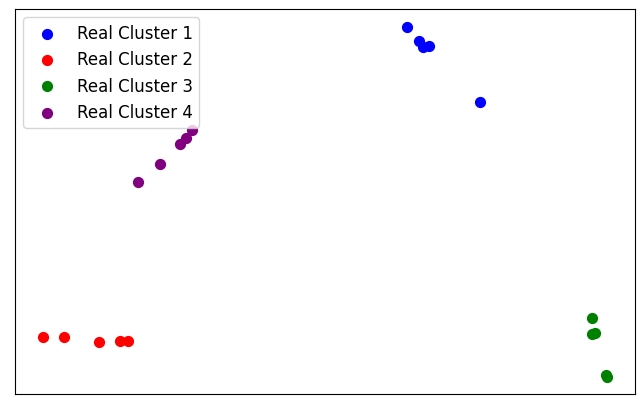

silhouette: 0.642884373664856, ari: 1.0
client 0 distill
client 10 distill
acc after global distill: 0.697, [0.927, 0.483, 0.47, 0.91], 0.919
acc after cluster distill: 0.934, [0.953, 0.933, 0.917, 0.933], 0.48
[[0, 1, 2, 3, 4], [4, 5, 6, 7, 8], [8, 9, 0, 1, 2], [2, 3, 4, 5, 6]]
Epoch 5 - Train Loss: 1.7673, Train Accuracy: 20.00%, Eval Accuracy: 20.00%
Epoch 10 - Train Loss: 1.3393, Train Accuracy: 58.29%, Eval Accuracy: 77.33%
Epoch 15 - Train Loss: 0.8559, Train Accuracy: 81.14%, Eval Accuracy: 77.33%
Epoch 20 - Train Loss: 0.4581, Train Accuracy: 91.43%, Eval Accuracy: 78.67%
Epoch 25 - Train Loss: 0.2622, Train Accuracy: 93.71%, Eval Accuracy: 81.33%
Global Logit's Accuracy: 70.88%
acc before distill: 0.908, [0.952, 0.885, 0.899, 0.896], 0.501
client 0 distill
client 10 distill
label_predicted:          0      1       2       3       4       5      6      7       8  \
0    836.0  641.0   728.0  1540.0  1255.0     0.0    0.0    0.0     0.0   
1    758.0  766.0   838.0  1141.0  1497

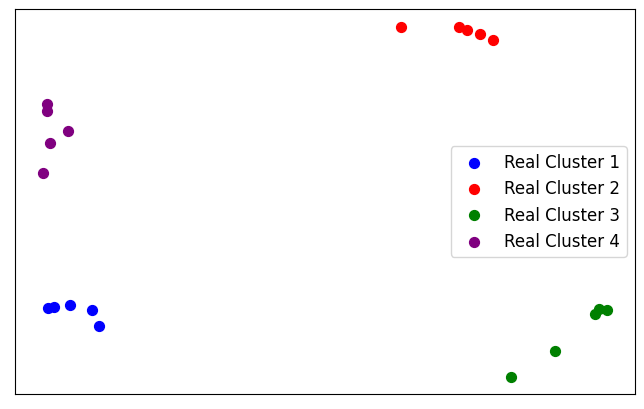

silhouette: 0.7576255798339844, ari: 1.0
client 0 distill
client 10 distill
acc after global distill: 0.765, [0.925, 0.611, 0.664, 0.861], 0.888
acc after cluster distill: 0.931, [0.968, 0.901, 0.941, 0.912], 0.507
[[0], [1], [2], [3], [4], [5]]
Epoch 5 - Train Loss: 1.8581, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 10 - Train Loss: 0.7387, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 15 - Train Loss: 0.0247, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 20 - Train Loss: 0.0002, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 25 - Train Loss: 0.0000, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 30 - Train Loss: 0.0000, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Global Logit's Accuracy: 14.94%
acc before distill: 1.0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 0.167
client 0 distill
client 10 distill
client 20 distill
label_predicted:          0       1       2       3       4       5    6    7    8    9
0   5000.0     0.0     0.0     0.0     0.0   

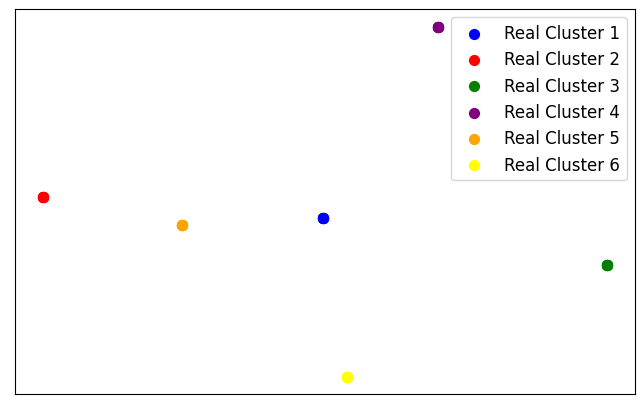

silhouette: 1.0, ari: 1.0
client 0 distill
client 10 distill
client 20 distill
acc after global distill: 0.14, [0.147, 0.12, 0.12, 0.253, 0.107, 0.093], 0.18
acc after cluster distill: 1.0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 0.167
[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [0, 5]]
Epoch 5 - Train Loss: 2.2088, Train Accuracy: 50.00%, Eval Accuracy: 50.00%
Epoch 10 - Train Loss: 1.6584, Train Accuracy: 50.00%, Eval Accuracy: 50.00%
Epoch 15 - Train Loss: 0.9711, Train Accuracy: 50.00%, Eval Accuracy: 50.00%
Epoch 20 - Train Loss: 0.6861, Train Accuracy: 50.00%, Eval Accuracy: 50.00%
Global Logit's Accuracy: 18.88%
acc before distill: 0.917, [1.0, 0.76, 0.933, 0.987, 0.88, 0.94], 0.228
client 0 distill
client 10 distill
client 20 distill
label_predicted:          0       1       2       3       4       5       6       7       8  \
0   3569.0  1431.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1   3638.0  1362.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2   3142

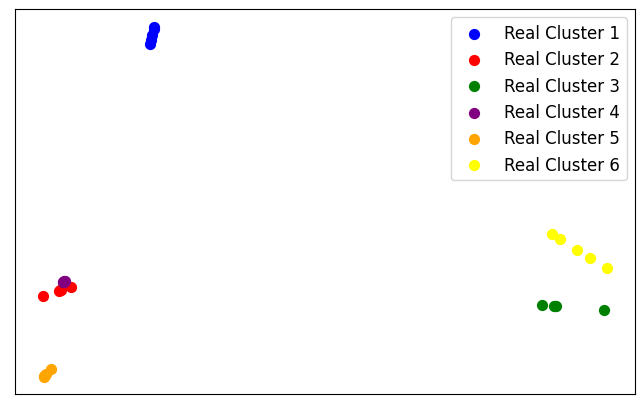

silhouette: 0.8109347224235535, ari: 0.7555943039814007
client 0 distill
client 10 distill
client 20 distill
acc after global distill: 0.306, [0.48, 0.0, 0.44, 0.007, 0.0, 0.907], 0.411
acc after cluster distill: 0.811, [1.0, 0.84, 0.573, 0.993, 0.907, 0.553], 0.177
[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1], [2, 3, 4], [5, 6, 7]]
Epoch 5 - Train Loss: 2.0640, Train Accuracy: 45.71%, Eval Accuracy: 51.11%
Epoch 10 - Train Loss: 1.4515, Train Accuracy: 61.90%, Eval Accuracy: 48.89%
Epoch 15 - Train Loss: 0.9968, Train Accuracy: 72.38%, Eval Accuracy: 55.56%
Epoch 20 - Train Loss: 0.8703, Train Accuracy: 82.86%, Eval Accuracy: 75.56%
Epoch 25 - Train Loss: 0.6947, Train Accuracy: 88.57%, Eval Accuracy: 80.00%
Epoch 30 - Train Loss: 0.4973, Train Accuracy: 90.48%, Eval Accuracy: 86.67%
Global Logit's Accuracy: 65.72%
acc before distill: 0.907, [0.942, 0.844, 0.92, 0.92, 0.884, 0.929], 0.314
client 0 distill
client 10 distill
client 20 distill
label_predicted:          0       1       2  

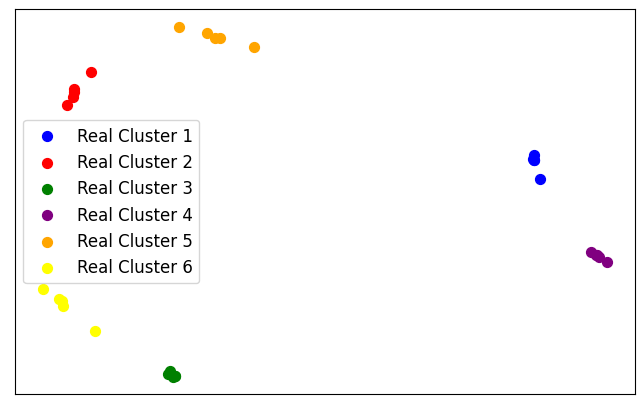

silhouette: 0.7511770725250244, ari: 1.0
client 0 distill
client 10 distill
client 20 distill
acc after global distill: 0.719, [0.88, 0.733, 0.538, 0.631, 0.822, 0.707], 0.915
acc after cluster distill: 0.935, [0.964, 0.916, 0.929, 0.933, 0.911, 0.956], 0.317
[[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 0, 1], [2, 3, 4, 5], [6, 7, 8, 9], [2, 4, 6, 8]]
Epoch 5 - Train Loss: 1.8352, Train Accuracy: 43.57%, Eval Accuracy: 26.67%
Epoch 10 - Train Loss: 1.2132, Train Accuracy: 29.29%, Eval Accuracy: 61.67%
Epoch 15 - Train Loss: 0.8734, Train Accuracy: 80.71%, Eval Accuracy: 75.00%
Epoch 20 - Train Loss: 0.6196, Train Accuracy: 90.71%, Eval Accuracy: 91.67%
Epoch 25 - Train Loss: 0.2069, Train Accuracy: 97.14%, Eval Accuracy: 91.67%
Epoch 30 - Train Loss: 0.2150, Train Accuracy: 96.43%, Eval Accuracy: 95.00%
Global Logit's Accuracy: 71.34%
acc before distill: 0.847, [0.907, 0.937, 0.883, 0.84, 0.763, 0.753], 0.326
client 0 distill
client 10 distill
client 20 distill
label_predicted:          0      

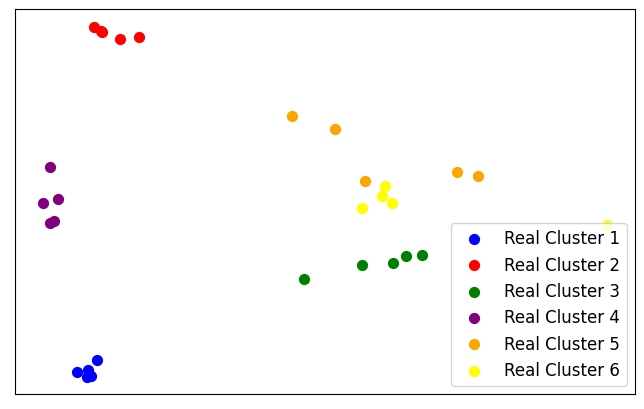

silhouette: 0.5561415553092957, ari: 0.8495460440985733
client 0 distill
client 10 distill
client 20 distill
acc after global distill: 0.702, [0.663, 0.777, 0.62, 0.593, 0.643, 0.913], 0.768
acc after cluster distill: 0.88, [0.943, 0.95, 0.923, 0.87, 0.71, 0.883], 0.34
[[0, 1, 2, 3, 4], [4, 5, 6, 7, 8], [8, 9, 0, 1, 2], [2, 3, 4, 5, 6], [6, 7, 8, 9, 0], [2, 4, 6, 8, 0]]
Epoch 5 - Train Loss: 1.6463, Train Accuracy: 28.57%, Eval Accuracy: 37.33%
Epoch 10 - Train Loss: 1.2349, Train Accuracy: 54.86%, Eval Accuracy: 65.33%
Epoch 15 - Train Loss: 0.8952, Train Accuracy: 76.57%, Eval Accuracy: 74.67%
Epoch 20 - Train Loss: 0.4955, Train Accuracy: 85.71%, Eval Accuracy: 81.33%
Epoch 25 - Train Loss: 0.3004, Train Accuracy: 91.43%, Eval Accuracy: 92.00%
Epoch 30 - Train Loss: 0.2227, Train Accuracy: 93.71%, Eval Accuracy: 94.67%
Global Logit's Accuracy: 59.20%
acc before distill: 0.9, [0.947, 0.888, 0.909, 0.869, 0.901, 0.888], 0.49
client 0 distill
client 10 distill
client 20 distill
label_p

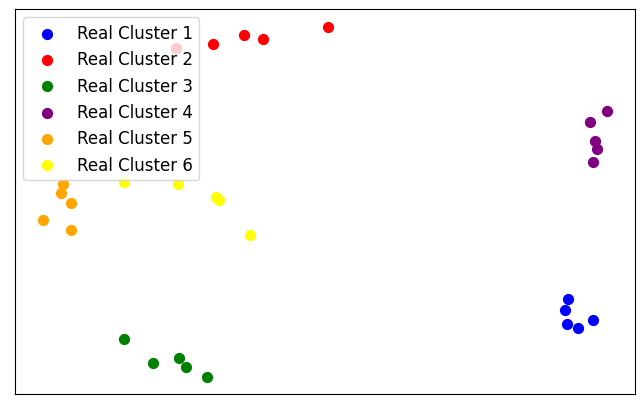

silhouette: 0.7090879082679749, ari: 1.0
client 0 distill
client 10 distill
client 20 distill
acc after global distill: 0.669, [0.6, 0.683, 0.573, 0.547, 0.68, 0.931], 0.562
acc after cluster distill: 0.926, [0.965, 0.912, 0.936, 0.912, 0.907, 0.925], 0.496
[[0], [1], [2], [3], [4], [5], [6], [7]]
Epoch 5 - Train Loss: 1.9015, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 10 - Train Loss: 0.9345, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 15 - Train Loss: 0.0511, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 20 - Train Loss: 0.0006, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 25 - Train Loss: 0.0000, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 30 - Train Loss: 0.0000, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Global Logit's Accuracy: 11.46%
acc before distill: 1.0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 0.125
client 0 distill
client 10 distill
client 20 distill
client 30 distill
label_predicted:          0       1       2       3 

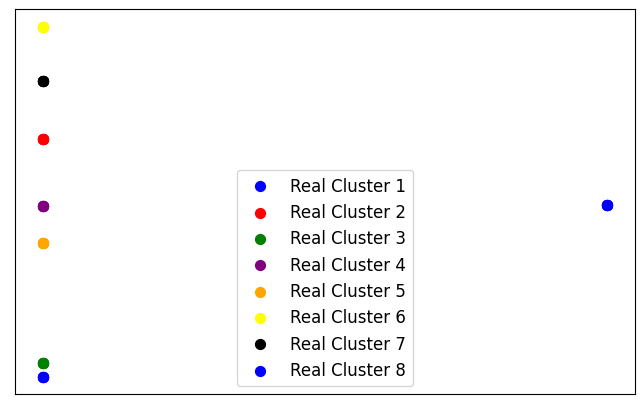

silhouette: 1.0, ari: 1.0
client 0 distill
client 10 distill
client 20 distill
client 30 distill
acc after global distill: 0.148, [0.213, 0.253, 0.16, 0.093, 0.053, 0.08, 0.307, 0.027], 0.131
acc after cluster distill: 1.0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 0.125
[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [0, 5], [1, 6], [2, 7]]
Epoch 5 - Train Loss: 1.9888, Train Accuracy: 50.00%, Eval Accuracy: 50.00%
Epoch 10 - Train Loss: 1.0618, Train Accuracy: 50.00%, Eval Accuracy: 50.00%
Epoch 15 - Train Loss: 0.6141, Train Accuracy: 64.29%, Eval Accuracy: 66.67%
Epoch 20 - Train Loss: 0.5174, Train Accuracy: 92.86%, Eval Accuracy: 100.00%
Epoch 25 - Train Loss: 0.4181, Train Accuracy: 94.29%, Eval Accuracy: 93.33%
Epoch 30 - Train Loss: 0.3119, Train Accuracy: 95.71%, Eval Accuracy: 93.33%
Global Logit's Accuracy: 50.00%
acc before distill: 0.94, [1.0, 0.887, 0.96, 1.0, 0.893, 0.947, 0.887, 0.947], 0.243
client 0 distill
client 10 distill
client 20 distill
client 30 distill
label_predict

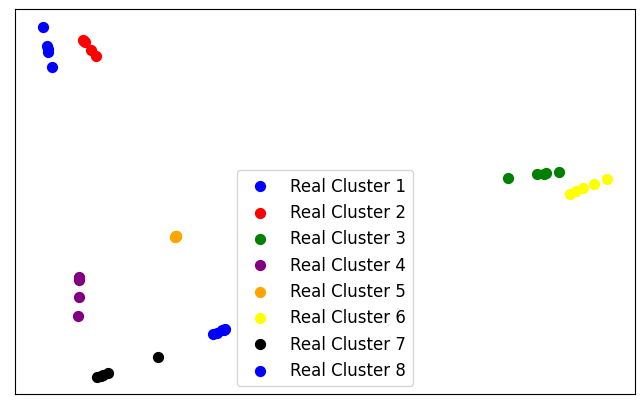

silhouette: 0.8126643896102905, ari: 0.8190689489681651
client 0 distill
client 10 distill
client 20 distill
client 30 distill
acc after global distill: 0.591, [0.813, 0.353, 0.34, 0.813, 0.0, 0.773, 0.813, 0.82], 0.826
acc after cluster distill: 0.856, [0.993, 0.913, 0.62, 1.0, 0.92, 0.56, 0.887, 0.953], 0.205
[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1], [2, 3, 4], [5, 6, 7], [8, 9, 0], [1, 2, 3]]
Epoch 5 - Train Loss: 2.0566, Train Accuracy: 51.43%, Eval Accuracy: 51.11%
Epoch 10 - Train Loss: 1.4481, Train Accuracy: 53.33%, Eval Accuracy: 44.44%
Epoch 15 - Train Loss: 1.0254, Train Accuracy: 62.86%, Eval Accuracy: 75.56%
Epoch 20 - Train Loss: 0.9130, Train Accuracy: 84.76%, Eval Accuracy: 66.67%
Epoch 25 - Train Loss: 0.7500, Train Accuracy: 96.19%, Eval Accuracy: 86.67%
Epoch 30 - Train Loss: 0.5273, Train Accuracy: 97.14%, Eval Accuracy: 86.67%
Global Logit's Accuracy: 53.22%
acc before distill: 0.912, [0.938, 0.831, 0.942, 0.938, 0.907, 0.893, 0.92, 0.929], 0.352
client 0 distil

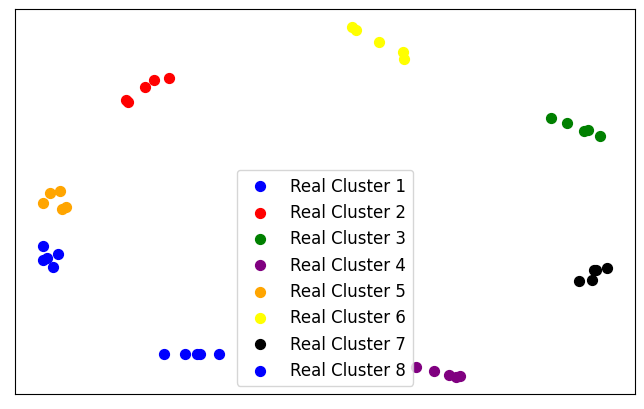

silhouette: 0.7058067321777344, ari: 1.0
client 0 distill
client 10 distill
client 20 distill
client 30 distill
acc after global distill: 0.58, [0.898, 0.418, 0.164, 0.858, 0.644, 0.107, 0.653, 0.898], 0.932
acc after cluster distill: 0.934, [0.964, 0.849, 0.973, 0.951, 0.929, 0.951, 0.929, 0.924], 0.355
[[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 0, 1], [2, 3, 4, 5], [6, 7, 8, 9], [2, 4, 6, 8], [1, 3, 5, 9], [0, 3, 6, 9]]
Epoch 5 - Train Loss: 1.6776, Train Accuracy: 25.00%, Eval Accuracy: 25.00%
Epoch 10 - Train Loss: 1.0965, Train Accuracy: 60.71%, Eval Accuracy: 66.67%
Epoch 15 - Train Loss: 0.5795, Train Accuracy: 92.14%, Eval Accuracy: 73.33%
Epoch 20 - Train Loss: 0.3132, Train Accuracy: 94.29%, Eval Accuracy: 88.33%
Epoch 25 - Train Loss: 0.1482, Train Accuracy: 94.29%, Eval Accuracy: 88.33%
Global Logit's Accuracy: 64.52%
acc before distill: 0.856, [0.91, 0.93, 0.843, 0.777, 0.833, 0.69, 0.913, 0.95], 0.339
client 0 distill
client 10 distill
client 20 distill
client 30 distill
label_p

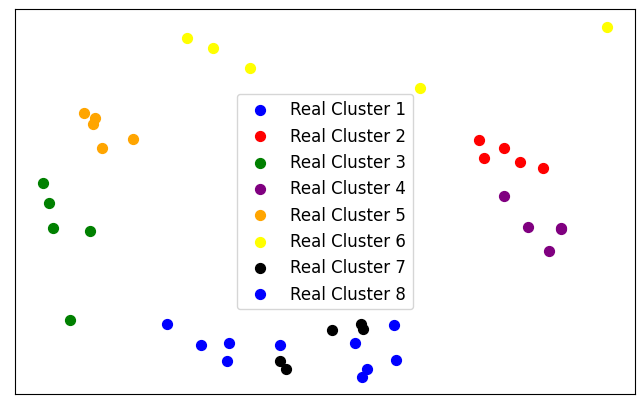

silhouette: 0.43844813108444214, ari: 0.76731852833941
client 0 distill
client 10 distill
client 20 distill
client 30 distill
acc after global distill: 0.666, [0.777, 0.443, 0.75, 0.507, 0.62, 0.497, 0.817, 0.92], 0.796
acc after cluster distill: 0.84, [0.94, 0.937, 0.853, 0.8, 0.853, 0.453, 0.923, 0.963], 0.359
[[0, 1, 2, 3, 4], [4, 5, 6, 7, 8], [8, 9, 0, 1, 2], [2, 3, 4, 5, 6], [6, 7, 8, 9, 0], [2, 4, 6, 8, 0], [1, 3, 5, 7, 9], [0, 2, 3, 6, 9]]
Epoch 5 - Train Loss: 1.6759, Train Accuracy: 20.00%, Eval Accuracy: 20.00%
Epoch 10 - Train Loss: 1.3264, Train Accuracy: 61.14%, Eval Accuracy: 56.00%
Epoch 15 - Train Loss: 0.8303, Train Accuracy: 80.57%, Eval Accuracy: 73.33%
Epoch 20 - Train Loss: 0.5244, Train Accuracy: 86.29%, Eval Accuracy: 74.67%
Epoch 25 - Train Loss: 0.3469, Train Accuracy: 88.57%, Eval Accuracy: 81.33%
Epoch 30 - Train Loss: 0.2311, Train Accuracy: 92.57%, Eval Accuracy: 85.33%
Global Logit's Accuracy: 80.78%
acc before distill: 0.894, [0.936, 0.883, 0.915, 0.877, 

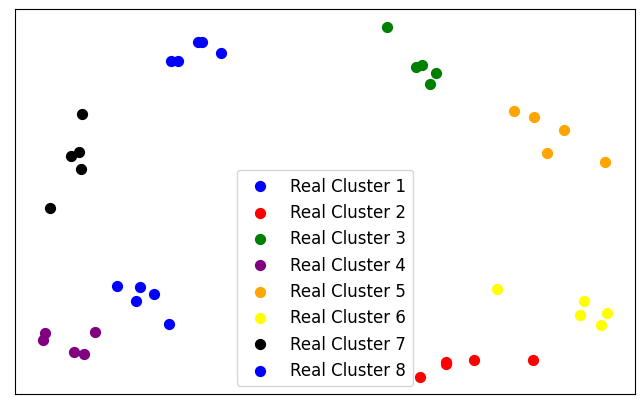

silhouette: 0.7221089005470276, ari: 1.0
client 0 distill
client 10 distill
client 20 distill
client 30 distill
acc after global distill: 0.778, [0.832, 0.555, 0.851, 0.72, 0.843, 0.832, 0.669, 0.925], 0.832
acc after cluster distill: 0.916, [0.944, 0.907, 0.933, 0.888, 0.907, 0.907, 0.912, 0.931], 0.489
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]
Epoch 5 - Train Loss: 1.9703, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 10 - Train Loss: 1.1003, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 15 - Train Loss: 0.1004, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 20 - Train Loss: 0.0013, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 25 - Train Loss: 0.0000, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Epoch 30 - Train Loss: 0.0000, Train Accuracy: 100.00%, Eval Accuracy: 100.00%
Global Logit's Accuracy: 12.56%
acc before distill: 1.0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 0.1
client 0 distill
client 10 distill
client 20 distill
clie

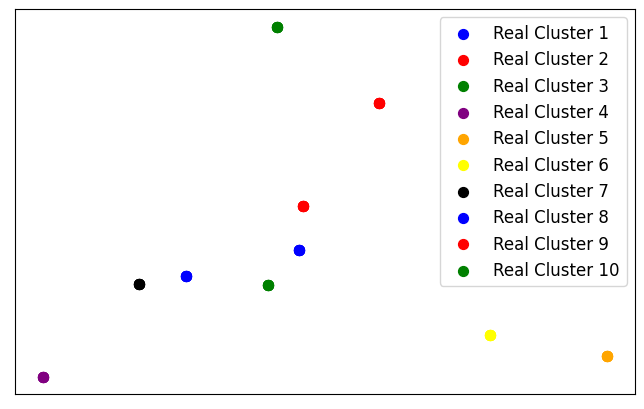

silhouette: 1.0, ari: 1.0
client 0 distill
client 10 distill
client 20 distill
client 30 distill
client 40 distill
acc after global distill: 0.099, [0.027, 0.16, 0.147, 0.133, 0.08, 0.067, 0.053, 0.093, 0.147, 0.08], 0.091
acc after cluster distill: 1.0, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 0.1
[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9], [0, 5], [1, 6], [2, 7], [3, 8], [4, 9]]
Epoch 5 - Train Loss: 1.7300, Train Accuracy: 50.00%, Eval Accuracy: 50.00%
Epoch 10 - Train Loss: 0.8707, Train Accuracy: 50.00%, Eval Accuracy: 50.00%
Global Logit's Accuracy: 51.36%
acc before distill: 0.905, [0.993, 0.827, 0.94, 0.993, 0.84, 0.927, 0.98, 0.98, 0.793, 0.78], 0.193
client 0 distill
client 10 distill
client 20 distill
client 30 distill
client 40 distill
label_predicted:          0       1       2       3       4       5       6       7       8  \
0   3424.0  1576.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1   2624.0  2376.0     0.0     0.0     0.0     0.0     0.0   

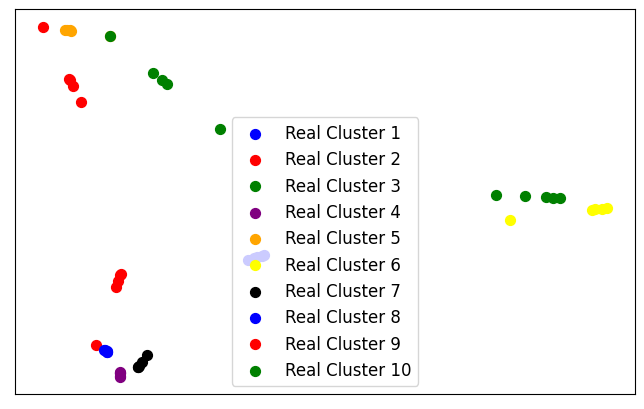

silhouette: 0.7280115485191345, ari: 0.9028848271305879
client 0 distill
client 10 distill
client 20 distill
client 30 distill
client 40 distill
acc after global distill: 0.499, [0.833, 0.287, 0.44, 0.84, 0.12, 0.72, 0.88, 0.573, 0.207, 0.087], 0.781
acc after cluster distill: 0.916, [0.993, 0.84, 0.94, 1.0, 0.84, 0.913, 0.96, 0.973, 0.88, 0.82], 0.194
[[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 0, 1], [2, 3, 4], [5, 6, 7], [8, 9, 0], [1, 2, 3], [4, 5, 6], [7, 8, 9]]
Epoch 5 - Train Loss: 2.0674, Train Accuracy: 34.29%, Eval Accuracy: 33.33%
Epoch 10 - Train Loss: 1.4492, Train Accuracy: 43.81%, Eval Accuracy: 55.56%
Epoch 15 - Train Loss: 1.0443, Train Accuracy: 55.24%, Eval Accuracy: 77.78%
Epoch 20 - Train Loss: 0.9575, Train Accuracy: 78.10%, Eval Accuracy: 64.44%
Epoch 25 - Train Loss: 0.8450, Train Accuracy: 91.43%, Eval Accuracy: 93.33%
Epoch 30 - Train Loss: 0.6821, Train Accuracy: 96.19%, Eval Accuracy: 93.33%
Global Logit's Accuracy: 74.04%
acc before distill: 0.916, [0.96, 0.858, 

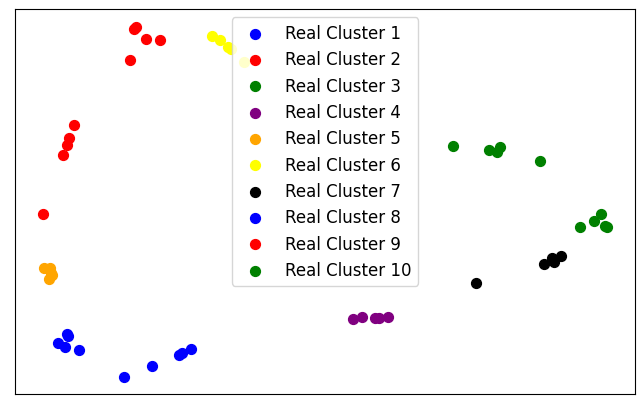

silhouette: 0.6505825519561768, ari: 1.0
client 0 distill
client 10 distill
client 20 distill
client 30 distill
client 40 distill
acc after global distill: 0.704, [0.853, 0.529, 0.636, 0.849, 0.724, 0.573, 0.742, 0.778, 0.609, 0.747], 0.885
acc after cluster distill: 0.944, [0.964, 0.911, 0.933, 0.951, 0.951, 0.973, 0.938, 0.942, 0.951, 0.92], 0.286
[[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 0, 1], [2, 3, 4, 5], [6, 7, 8, 9], [2, 4, 6, 8], [1, 3, 5, 9], [0, 3, 6, 9], [1, 4, 7, 0], [2, 5, 8, 1]]
Epoch 5 - Train Loss: 1.9772, Train Accuracy: 32.86%, Eval Accuracy: 40.00%
Epoch 10 - Train Loss: 1.2877, Train Accuracy: 62.86%, Eval Accuracy: 38.33%
Epoch 15 - Train Loss: 1.2364, Train Accuracy: 44.29%, Eval Accuracy: 56.67%
Epoch 20 - Train Loss: 0.9002, Train Accuracy: 70.71%, Eval Accuracy: 75.00%
Epoch 25 - Train Loss: 0.4328, Train Accuracy: 95.00%, Eval Accuracy: 95.00%
Epoch 30 - Train Loss: 0.2355, Train Accuracy: 95.00%, Eval Accuracy: 93.33%
Global Logit's Accuracy: 78.86%
acc before dis

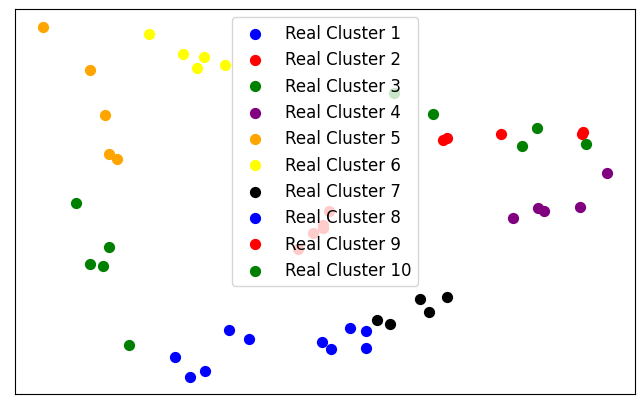

silhouette: 0.5752784013748169, ari: 1.0
client 0 distill
client 10 distill
client 20 distill
client 30 distill
client 40 distill
acc after global distill: 0.788, [0.83, 0.76, 0.783, 0.79, 0.687, 0.773, 0.843, 0.813, 0.807, 0.793], 0.914
acc after cluster distill: 0.921, [0.953, 0.953, 0.91, 0.897, 0.873, 0.917, 0.92, 0.963, 0.96, 0.867], 0.425
[[0, 1, 2, 3, 4], [4, 5, 6, 7, 8], [8, 9, 0, 1, 2], [2, 3, 4, 5, 6], [6, 7, 8, 9, 0], [2, 4, 6, 8, 0], [1, 3, 5, 7, 9], [0, 2, 3, 6, 9], [1, 4, 6, 7, 0], [2, 5, 6, 8, 1]]
Epoch 5 - Train Loss: 1.8097, Train Accuracy: 36.00%, Eval Accuracy: 38.67%
Epoch 10 - Train Loss: 1.3504, Train Accuracy: 52.00%, Eval Accuracy: 57.33%
Epoch 15 - Train Loss: 0.9248, Train Accuracy: 87.43%, Eval Accuracy: 80.00%
Epoch 20 - Train Loss: 0.4538, Train Accuracy: 89.14%, Eval Accuracy: 84.00%
Epoch 25 - Train Loss: 0.3383, Train Accuracy: 91.43%, Eval Accuracy: 88.00%
Epoch 30 - Train Loss: 0.2182, Train Accuracy: 96.57%, Eval Accuracy: 92.00%
Global Logit's Accura

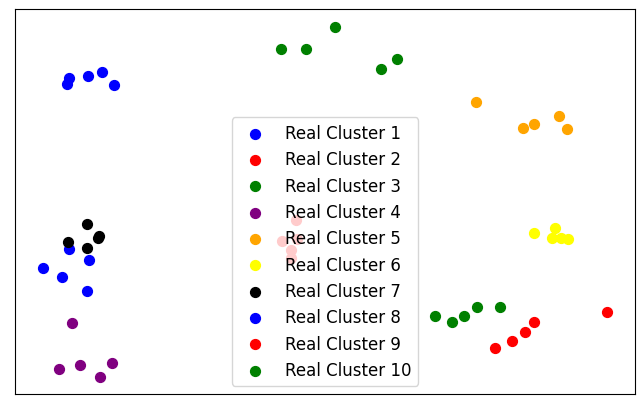

silhouette: 0.735974133014679, ari: 1.0
client 0 distill
client 10 distill
client 20 distill
client 30 distill
client 40 distill
acc after global distill: 0.78, [0.877, 0.773, 0.781, 0.768, 0.728, 0.875, 0.525, 0.725, 0.907, 0.84], 0.932
acc after cluster distill: 0.922, [0.939, 0.931, 0.904, 0.928, 0.904, 0.904, 0.925, 0.936, 0.973, 0.877], 0.53


In [8]:
# Initialize empty DataFrames to store results with multi-level columns
multi_col = pd.MultiIndex.from_product([range(1, 6), ['before_distill', 'global_distill', 'cluster_distill']], names=['class_per_cluster', 'Metric'])
df_client_accs = pd.DataFrame(columns=multi_col)
df_cluster_accs = pd.DataFrame(columns=multi_col)
df_global_accs = pd.DataFrame(columns=multi_col)

# Iterate over different cluster_count values
for cluster_count in [2, 4, 6, 8, 10]:
    # Iterate over different class_per_cluster values
    for class_per_cluster in range(1, 6):
        n_clients = cluster_count * 5
        instances_per_class_per_client = get_combination(cluster_count, class_per_cluster)
        print(instances_per_class_per_client)
        # Replace with your actual cluster_train_result_exp function
        client_accs, cluster_accs, global_accs = cluster_train_result_exp(
        n_clients, 50000, 5000, cluster_count, [1/cluster_count] * cluster_count, 50, instances_per_class_per_client
    )     
        # Update DataFrame
        df_client_accs.loc[cluster_count, (class_per_cluster, 'before_distill')] = client_accs[0]
        df_client_accs.loc[cluster_count, (class_per_cluster, 'global_distill')] = client_accs[1]
        df_client_accs.loc[cluster_count, (class_per_cluster, 'cluster_distill')] = client_accs[2]

        df_cluster_accs.loc[cluster_count, (class_per_cluster, 'before_distill')] = cluster_accs[0]
        df_cluster_accs.loc[cluster_count, (class_per_cluster, 'global_distill')] = cluster_accs[1]
        df_cluster_accs.loc[cluster_count, (class_per_cluster, 'cluster_distill')] = cluster_accs[2]

        df_global_accs.loc[cluster_count, (class_per_cluster, 'before_distill')] = global_accs[0]
        df_global_accs.loc[cluster_count, (class_per_cluster, 'global_distill')] = global_accs[1]
        df_global_accs.loc[cluster_count, (class_per_cluster, 'cluster_distill')] = global_accs[2]

In [9]:
df_client_accs

class_per_cluster              1                                 \
Metric            before_distill global_distill cluster_distill   
2                            1.0          0.453             1.0   
4                            1.0          0.303             1.0   
6                            1.0           0.14             1.0   
8                            1.0          0.148             1.0   
10                           1.0          0.099             1.0   

class_per_cluster              2                                 \
Metric            before_distill global_distill cluster_distill   
2                           0.91          0.713           0.953   
4                          0.972          0.548           0.983   
6                          0.917          0.306           0.811   
8                           0.94          0.591           0.856   
10                         0.905          0.499           0.916   

class_per_cluster              3                                 \
Metric            before_distill global_distill cluster_distill   
2                           0.88          0.709           0.907   
4                          0.893          0.494           0.931   
6                          0.907          0.719           0.935   
8                          0.912           0.58           0.934   
10                         0.916          0.704           0.944   

class_per_cluster              4                                 \
Metric            before_distill global_distill cluster_distill   
2                          0.883          0.788           0.955   
4                          0.909          0.697           0.934   
6                          0.847          0.702            0.88   
8                          0.856          0.666            0.84   
10                         0.891          0.788           0.921   

class_per_cluster              5                                 
Metric            before_distill global_distill cluster_distill  
2                          0.928          0.777           0.937  
4                          0.908          0.765           0.931  
6                            0.9          0.669           0.926  
8                          0.894          0.778           0.916  
10                           0.9           0.78           0.922

In [14]:
df_client_accs.mean()

class_per_cluster  Metric         
1                  before_distill     1.0000
                   global_distill     0.2286
                   cluster_distill    1.0000
2                  before_distill     0.9288
                   global_distill     0.5314
                   cluster_distill    0.9038
3                  before_distill     0.9016
                   global_distill     0.6412
                   cluster_distill    0.9302
4                  before_distill     0.8772
                   global_distill     0.7282
                   cluster_distill    0.9060
5                  before_distill     0.9060
                   global_distill     0.7538
                   cluster_distill    0.9264
dtype: float64

In [15]:
df_mean = df_client_accs.mean()
df_mean = df_mean.reset_index()
df_mean.columns = ['class_per_cluster', 'Metric', 'Value']

# Pivot the table so Metrics become columns
df_pivot = df_mean.pivot(index='class_per_cluster', columns='Metric', values='Value')

# Create a new feature
df_pivot['cluster_global_diff'] = df_pivot['cluster_distill'] - df_pivot['global_distill']

# Reset the index for the final DataFrame
df_pivot.reset_index(inplace=True)

print(df_pivot)

Metric  class_per_cluster  before_distill  cluster_distill  global_distill  \
0                       1          1.0000           1.0000          0.2286   
1                       2          0.9288           0.9038          0.5314   
2                       3          0.9016           0.9302          0.6412   
3                       4          0.8772           0.9060          0.7282   
4                       5          0.9060           0.9264          0.7538   

Metric  cluster_global_diff  
0                    0.7714  
1                    0.3724  
2                    0.2890  
3                    0.1778  
4                    0.1726  


In [10]:
df_global_accs

class_per_cluster              1                                 \
Metric            before_distill global_distill cluster_distill   
2                          0.434          0.439           0.434   
4                           0.25          0.269            0.25   
6                          0.167           0.18           0.167   
8                          0.125          0.131           0.125   
10                           0.1          0.091             0.1   

class_per_cluster              2                                 \
Metric            before_distill global_distill cluster_distill   
2                          0.491          0.925           0.494   
4                          0.246          0.832           0.246   
6                          0.228          0.411           0.177   
8                          0.243          0.826           0.205   
10                         0.193          0.781           0.194   

class_per_cluster              3                                 \
Metric            before_distill global_distill cluster_distill   
2                          0.476          0.942           0.479   
4                          0.445          0.924           0.451   
6                          0.314          0.915           0.317   
8                          0.352          0.932           0.355   
10                         0.284          0.885           0.286   

class_per_cluster              4                                 \
Metric            before_distill global_distill cluster_distill   
2                          0.466          0.919            0.47   
4                          0.473          0.919            0.48   
6                          0.326          0.768            0.34   
8                          0.339          0.796           0.359   
10                         0.417          0.914           0.425   

class_per_cluster              5                                 
Metric            before_distill global_distill cluster_distill  
2                          0.473          0.674            0.48  
4                          0.501          0.888           0.507  
6                           0.49          0.562           0.496  
8                          0.485          0.832           0.489  
10                         0.524          0.932            0.53

In [11]:
def Global_TC_experiments(total_client_data, distill_data, alpha, number_of_cluster, cluster_distribution):
    print(f'number_of_cluster: {number_of_cluster}')
    data_per_class=int(distill_data//10)
    train_idcs, test_idcs = idcs[:total_client_data], idcs[total_client_data:(total_client_data + int(distill_data * 2))]
    train_labels = data.targets
    test_labels = data.targets
    
    server_idcs = generate_server_idcs(test_idcs, test_labels, int(distill_data//10))

    # client_idcs = split_noniid(train_idcs, train_labels, alpha=alpha, n_clients=N_CLIENTS)
    client_idcs, major_class_per_client = split_7plus3class_unbalanced(train_idcs, train_labels, N_CLIENTS, cluster_distribution, data_per_class_3, data_per_class_7)
    
    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, server_idcs, transforms.Compose([transforms.ToTensor()]))

    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(ConvNet, lambda x : torch.optim.Adam(x),test_data)

    clients = [Client(Representation, dat, major_class_per_client[i], i) 
           for i, dat in enumerate(client_data) if len(dat) > 20]
    
    print(f'client count: {len(clients)}')

    client_accs = []
    cluster_accs = []
    global_accs = []
    client_logits = []
    
    # # 0. Representational Learning
    # for i, client in enumerate(clients):
    #     Total_data = CustomSubset(data, np.concatenate((server_idcs, client_idcs[i])), transforms.Compose([transforms.ToTensor()]))
    #     # print(f'data used to trian representation: {len(Total_data)}')
    #     client.learn_representation(Total_data)
        
    # 1. Train classifier
    for i, client in enumerate(clients):
        client.classifier = Ten_class_classifier(client.model).to(device)
        client.train_classifier(lr=1e-3)

    client_accs, cluster_accs, global_accs = test_acc(server, clients, client_accs, cluster_accs, global_accs, cluster_distribution)
    print(f'client_acc: {client_accs[-1]}, cluster_acc: {cluster_distribution}: {cluster_accs[-1]},  global_acc: {global_accs[-1]}')
    
    # 2. get cluster loigt
    for i, client in enumerate(clients):
        client_logits.append(server.get_clients_logit(client.classifier))
    

    # 3. make global logit
    global_logits = server.get_global_logits(client_logits)
    accuracy = compute_accuracy(global_logits, test_labels, server_idcs)
    
    print(f"Global Logit's Accuracy: {accuracy * 100:.2f}%") 
    
    
     # 4. Distillation
    distill_loader = server.create_distill_loader(data, server_idcs, global_logits)
    
    for i, client in enumerate(clients):
        if i % 10 == 0:
            print(f'client {i} distill')
        client.distill(distill_loader)
    
    client_accs, cluster_accs, global_accs = test_acc(server, clients, client_accs, cluster_accs, global_accs, cluster_distribution)
    
    print(f'total_client_data: {total_client_data}, cluster_distribution: {cluster_distribution}')
    print(f'acc before distill: {client_accs[-2]}, {cluster_accs[-2]}, {global_accs[-2]}')
    print(f'last acc: {client_accs[-1]}, {cluster_accs[-1]}, {global_accs[-1]}')
    return client_accs, cluster_accs, global_accs

In [12]:
# TC_experiments(50000, 5000, 1, 3, [1/3, 1/3, 1/3], 117, 21)

In [13]:
clustering_by_model_experiments(50000, 5000, 1, 3, [1/3, 1/3, 1/3], 100, 0)

NameError: name 'clustering_by_model_experiments' is not defined

In [ ]:
now = datetime.datetime.now(pytz.timezone('Asia/Seoul'))
date_time = now.strftime("%m%d_%H%M")

columns = pd.MultiIndex.from_product([['client_accs', 'cluster_accs', 'global_accs'], ['before_distill', 'after_distill']],
                                     names=['acc_type', 'distill_state'])

desired_pairs = [(50000, 5000)]
cluster_distribution = [1/3, 1/3, 1/3]
experiments = ['cluster_distill', 'sim', 'global_distill']
index = pd.MultiIndex.from_product([experiments, desired_pairs], names=['experiment', 'data_pair'])

df = pd.DataFrame(index=index, columns=columns)
runs = 2  # number of times each experiment should be run

for exp in experiments:
    for pair in desired_pairs:
        total_client_accs = [0, 0]
        total_cluster_accs = [0, 0]
        total_global_accs = [0, 0]

        for _ in range(runs):
            client_data, distill_data = pair

            if exp == 'sim':
                client_accs, cluster_accs, global_accs = SimCLR_distill_experiments(client_data, distill_data, ALPHA, NUMBER_OF_CLUSTER, cluster_distribution)
            elif exp == 'global_distill':
                client_accs, cluster_accs, global_accs = global_distill_experiments(client_data, distill_data, ALPHA, NUMBER_OF_CLUSTER, cluster_distribution)
            else:
                client_accs, cluster_accs, global_accs = four_class_classification_experiments(client_data, distill_data, ALPHA, NUMBER_OF_CLUSTER, cluster_distribution)

            total_client_accs = [x+y for x, y in zip(total_client_accs, [client_accs[-2], client_accs[-1]])]
            total_cluster_accs = [x+y for x, y in zip(total_cluster_accs, [cluster_accs[-2], cluster_accs[-1]])]
            total_global_accs = [x+y for x, y in zip(total_global_accs, [global_accs[-2], global_accs[-1]])]

        avg_client_accs = [x/runs for x in total_client_accs]
        avg_cluster_accs = [x/runs for x in total_cluster_accs]
        avg_global_accs = [x/runs for x in total_global_accs]

        df.loc[(exp, pair), ('client_accs', 'before_distill')] = avg_client_accs[0]
        df.loc[(exp, pair), ('client_accs', 'after_distill')] = avg_client_accs[1]
        df.loc[(exp, pair), ('global_accs', 'before_distill')] = avg_global_accs[0]
        df.loc[(exp, pair), ('global_accs', 'after_distill')] = avg_global_accs[1]
        df.loc[(exp, pair), ('cluster_accs', 'before_distill')] = avg_cluster_accs[0]
        df.loc[(exp, pair), ('cluster_accs', 'after_distill')] = avg_cluster_accs[1]

directory = f'results/SimCLR'
if not os.path.exists(directory):
    os.makedirs(directory)
cluster_distribution_str = "_".join(map(str, cluster_distribution))
file_name = f'{directory}/client:{N_CLIENTS}_cluster:{NUMBER_OF_CLUSTER}_distribution:{cluster_distribution_str}_{date_time}.csv'
df = df.round(decimals=3)
df.to_csv(file_name)

In [ ]:
df = pd.read_csv('results/global_distill/CIFAR_0720_0435.csv', index_col=[0,1], header=[0,1])

# 그릴 데이터와 제목을 리스트로 저장
heatmap_data = [('client_accs', 'change_after_distill', 'Client Accuracy change after Distillation'),
                ('global_accs', 'change_after_distill', 'Global Accuracy change after Distillation')]

# Compute change in accuracy
df[('client_accs', 'change_after_distill')] = df[('client_accs', 'after_distill')] - df[('client_accs', 'before_distill')]
df[('global_accs', 'change_after_distill')] = df[('global_accs', 'after_distill')] - df[('global_accs', 'before_distill')]

# 전체 데이터의 최솟값, 최댓값 계산
vmin = min(df[data1][data2].min() for data1, data2, _ in heatmap_data)
vmax = max(df[data1][data2].max() for data1, data2, _ in heatmap_data)

for data1, data2, title in heatmap_data:
    plt.figure(figsize=(9, 5))
    sns.heatmap(df[(data1, data2)].unstack(), annot=True, cmap='coolwarm', center=0, vmin=-0.1, vmax=0.2)
    plt.title(title)
    plt.show()


## 2.Clustering 실험

In [ ]:
def do_clustering_experiments(total_client_data=total_client_data, data_per_class=data_per_class, ALPHA=ALPHA):
    train_idcs, test_idcs = idcs[:int(total_client_data*10)], idcs[int(total_client_data*10):]
    train_labels = data.train_labels.numpy()
    test_labels = data.train_labels.numpy()[int(total_client_data*10):]

    client_idcs = split_noniid(train_idcs, train_labels, alpha=ALPHA, n_clients=N_CLIENTS)#, data_per_class=int(total_client_data/10))
    # server_idcs = generate_server_idcs(test_idcs, test_labels, int(total_client_data*10))

    client_data = [CustomSubset(data, idcs) for idcs in client_idcs]
    test_data = CustomSubset(data, test_idcs, transforms.Compose([transforms.ToTensor()]))
    
    for i, client_datum in enumerate(client_data):
        client_datum.subset_transform = transforms.Compose([transforms.ToTensor()])

    server = Server(resnet18, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9),test_data)

    
    distillation_data_file = f'distillation_data_{data_per_class}_per_class.pth'

    # Check if the file already exists
    if not os.path.exists(distillation_data_file):
        # The file does not exist, generate and save the distillation data
        distillation_data = server.make_distillation_data(data_per_class=data_per_class)
        torch.save(distillation_data, distillation_data_file)

    # Load the distillation data
    distillation_data = torch.load(distillation_data_file)

    clients = [Client(resnet18, lambda x : torch.optim.SGD(x, lr=0.1, momentum=0.9), dat, i, distillation_data) 
               for i, dat in enumerate(client_data)]

    def aggregate(cluster_indices_new):
        cluster_indices = cluster_indices_new
        client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]

        server.aggregate_clusterwise(client_clusters)

        return cluster_indices

    cfl_stats = ExperimentLogger()

    cluster_indices = [np.arange(len(clients)).astype("int")]
    client_clusters = [[clients[i] for i in idcs] for idcs in cluster_indices]


    for epoch in range(1, LOCAL_EPOCHS+1):

        if epoch == 1:
            for client in clients:
                client.synchronize_with_server(server)

        participating_clients = server.select_clients(clients, frac=1.0)

        for client in participating_clients:
            if epoch == 1:
                client.distill()

            train_stats = client.compute_weight_update(epochs=1) #train client

            if epoch == 1000:
                client.reset()

        cluster_indices_new = []

        for idc in cluster_indices:
            max_norm = server.compute_max_update_norm([clients[i] for i in idc])
            mean_norm = server.compute_mean_update_norm([clients[i] for i in idc])

            #cluster 나누는 기준
            if epoch == LOCAL_EPOCHS: #무조건 한번 나누기
                similarities = server.compute_pairwise_similarities(clients)

                server.cache_model(idc, clients[idc[0]].W, acc_clients)

                c1, c2, c3 = server.cluster_clients_GMM(similarities[idc][:,idc])
                cluster_indices_new += [c1, c2, c3]

        if epoch == 1000:
            cluster_indices = aggregate(cluster_indices_new)

        acc_clients = [client.evaluate() for client in clients]

        if epoch == LOCAL_EPOCHS: #무조건 한번 나누기
            label_accuracies = pd.DataFrame()
            label_predicted = pd.DataFrame()
            label_soft_sum = pd.DataFrame()
            label_diff = pd.DataFrame()

            for i, client in enumerate(clients):
                acc, pred, sum_, diff = server.evaluate(client.model)
                # Convert each dictionary to a DataFrame and append to the respective DataFrame
                label_accuracies = label_accuracies.append(pd.DataFrame(acc, index=[i]))
                label_predicted = label_predicted.append(pd.DataFrame(pred, index=[i]))
                label_soft_sum = label_soft_sum.append(pd.DataFrame(sum_, index=[i]))
                label_diff = label_diff.append(pd.DataFrame(diff, index=[i]))

            # Reset index for all DataFrames
            label_accuracies.reset_index(drop=True, inplace=True)
            label_predicted.reset_index(drop=True, inplace=True)
            label_soft_sum.reset_index(drop=True, inplace=True)
            label_diff.reset_index(drop=True, inplace=True)

        if epoch == 1:
            first_accuracies = pd.DataFrame()
            for i, client in enumerate(clients):
                first_acc, pred, sum_, diff = server.evaluate(client.model)
                first_accuracies = pd.concat([first_accuracies, pd.DataFrame(first_acc, index=[i])])
            first_accuracies = first_accuracies.fillna(0)

            client_acc_after_distill = sum(acc_clients)/len(acc_clients)
            global_acc_after_distill = np.mean(np.ravel(first_accuracies.values))


        elif epoch == LOCAL_EPOCHS:
            client_acc_final = sum(acc_clients)/len(acc_clients)
            global_acc_final = np.mean(np.ravel(label_accuracies.values))

        average_dw = server.get_average_dw(clients)
        #print(average_dw)
        cfl_stats.log({"acc_clients" : acc_clients, "mean_norm" : mean_norm, "max_norm" : max_norm,
                      "rounds" : epoch, "clusters" : cluster_indices, "average_dw": average_dw})


        display_train_stats(cfl_stats, EPS_1, EPS_2, LOCAL_EPOCHS)


    for idc in cluster_indices:    
        server.cache_model(idc, clients[idc[0]].W, acc_clients)
    
    client_acc_after_distill = round(client_acc_after_distill, 3)
    global_acc_after_distill = round(global_acc_after_distill, 3)
    client_acc_final = round(client_acc_final, 3)
    global_acc_final = round(global_acc_final, 3)
    
    return client_acc_after_distill, global_acc_after_distill, client_acc_final, global_acc_final

    print(client_acc_after_distill, global_acc_after_distill)
    print(client_acc_final, global_acc_final)

In [ ]:
first_accuracies

In [ ]:
label_accuracies.sort_index(axis=1)

In [ ]:
label_soft_sum.sort_index(axis=1)

In [ ]:
label_diff.sort_index(axis=1)

In [ ]:
label_predicted.sort_index(axis=1)

In [ ]:
from sklearn.decomposition import PCA
# Instantiate PCA
pca = PCA(n_components=2)

# Apply PCA to the dataframes
label_accuracies_pca = pca.fit_transform(label_accuracies)
label_predicted_pca = pca.fit_transform(label_predicted)
label_soft_sum_pca = pca.fit_transform(label_soft_sum)
label_diff_pca = pca.fit_transform(label_diff)
transformed_data = pca.fit_transform(similarities)

# Create labels
labels = [0, 0, 0, 1, 1, 1, 2, 2, 2]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Scatter plots with larger dots
dot_size = 50
axs[0, 0].scatter(label_accuracies_pca[:, 0], label_accuracies_pca[:, 1], c=labels, s=dot_size)
axs[0, 0].set_title('Label Accuracies')
axs[0, 1].scatter(label_predicted_pca[:, 0], label_predicted_pca[:, 1], c=labels, s=dot_size)
axs[0, 1].set_title('Label Predicted')
axs[1, 0].scatter(label_soft_sum_pca[:, 0], label_soft_sum_pca[:, 1], c=labels, s=dot_size)
axs[1, 0].set_title('Label Soft Sum')
axs[1, 1].scatter(label_diff_pca[:, 0], label_diff_pca[:, 1], c=labels, s=dot_size)
axs[1, 1].set_title('Label Soft Diff')

plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate Silhouette Scores
silhouette_accuracies = silhouette_score(label_accuracies_pca, labels)
silhouette_predicted = silhouette_score(label_predicted_pca, labels)
silhouette_soft_sum = silhouette_score(label_soft_sum_pca, labels)
silhouette_diff = silhouette_score(label_diff_pca, labels)
silhouette_transformed_data = silhouette_score(transformed_data, labels)

print('Silhouette Score for Accuracies:', silhouette_accuracies)
print('Silhouette Score for Predicted:', silhouette_predicted)
print('Silhouette Score for Soft Sum:', silhouette_soft_sum)
print('Silhouette Score for diff:', silhouette_diff)
print('Silhouette Score for Model params:', silhouette_transformed_data)



In [ ]:
#df.sort_index(axis=1)

데이터 Cluster 별 모델 파라미터 분포

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Fit and transform your data to 2D
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(similarities)

# Assign labels based on index ranges
labels = [0, 0, 0, 1, 1, 1, 2, 2, 2]
unique_labels = np.unique(labels)
colors = plt.cm.Spectral(np.linspace(0, 0.35, len(unique_labels)))

# Plot the transformed data with labels
for label, color in zip(unique_labels, colors):
    idx = np.where(labels == label)
    plt.scatter(transformed_data[idx, 0], transformed_data[idx, 1], color=color, label=f'Cluster {label}')

# Add a legend
plt.legend()

plt.show()
